<a href="https://colab.research.google.com/github/LondheShubham153/natural_language_processing/blob/main/restaurant_reviews_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages and Imports 

Supressed warnings

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading Data

In [ ]:
data = pd.read_csv('Restaurant_Reviews.tsv', sep="\t")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


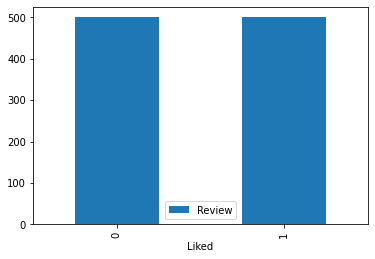

In [ ]:
data.groupby('Liked').count().plot.bar()

## Text Pre Processing and NLP techniques

In [ ]:
class PreProcessor:

  def remove_punctuation(self, record):

    cleaned_str = [char for char in record if char not in string.punctuation]
    return ''.join(cleaned_str)
  
  def normalize_sentences(self, sentences):
    words = sentences.split(" ")
    return [word.lower() for word in words]

  def remove_stopwords(self,words):
    return [word for word in words if word not in stopwords.words("english")]

  def process(self, record):
      # Remove Punctuation
      sentences = self.remove_punctuation(record)
      
      # Normalize
      norm_words = self.normalize_sentences(sentences)
      
      # Remove Stopwords
      final_words = self.remove_stopwords(norm_words)
      
      return final_words

In [ ]:
# Extract features and labels

features = data.iloc[:,0].values
label = data.iloc[:,[1]].values

In [ ]:
processor = PreProcessor()

word_vector = CountVectorizer(analyzer=processor.process)
# Build Vocab
final_word_vocab = word_vector.fit(features)
# Build Bag of Words
bag_of_words = final_word_vocab.transform(features)

In [ ]:
# Calculating TF and IDF
tfIdf_obj = TfidfTransformer().fit(bag_of_words)

# Transform data (Calc Weights )
final_feature = tfIdf_obj.transform(bag_of_words)

## Model Selection

In [ ]:
class ModelBuilder:
  def __init__(self):
    self.names = [
    "Nearest Neighbors",
    "Linear SVM",
    "Decision Tree",
    "Logistic_Regression"]

    self.classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression()]


  def split_test_train(self, features,labels,size,state):
    X_train,X_test,y_train,y_test = train_test_split(features,
                                                label,
                                                test_size=size,
                                                random_state=state)
    return (X_train,X_test,y_train,y_test)

  def choose_best_model(self,X_test,X_train,y_test,y_train):
    scores = []
    best_model = self.classifiers[0]
    best_score = 0
    for name, clf in zip(self.names,self.classifiers):
      clf.fit(X_train,y_train)
      score = clf.score(X_test,y_test)
      scores.append(score)
      if score > best_score:
        best_model = clf
        best_score = score
    model_scores_df = pd.DataFrame()
    model_scores_df['Algorithm'] = self.names
    model_scores_df['Score'] = scores

    cm = sns.light_palette('orange',as_cmap=True)
    model_scores = model_scores_df.style.background_gradient(cmap=cm)
    print(f"The model that will perform well with {best_model}")
    return model_scores, best_model
  


In [ ]:
models = ModelBuilder()
X_test,X_train,y_test,y_train = models.split_test_train(final_feature,label,0.2,6)
scores,model = models.choose_best_model(X_test,X_train,y_test,y_train)
model.fit(X_train,y_train)
scores

The model that will perform well LogisticRegression()


,Algorithm,Score
0,Nearest Neighbors,0.706250
1,Linear SVM,0.495000
2,Decision Tree,0.635000
3,Logistic_Regression,0.730000


In [ ]:
class ResturantReview:

  def predict(self,model,review_comment):
    """
    Pre Processing
    BOW transformation
    TFIDF transformation

    """
    review_dict = {
        0:"Disiked",
        1:"Liked",
        
    }
    pre_processed_features = processor.process(review_comment)
    bow_feature = final_word_vocab.transform(pre_processed_features)
    tfIdf_feature = tfIdf_obj.transform(bow_feature)
    return review_dict.get(max(set(model.predict(tfIdf_feature)), key = list(model.predict(tfIdf_feature)).count))

In [ ]:
reviewer = ResturantReview()
reviewer.predict(model,"What a bad taste, I don't recommend this restaurant")

'Disiked'

In [ ]:
reviewer = ResturantReview()
reviewer.predict(model,"Lovely taste, this resturant has the best service")

'Liked'

## Conclusion

Dataset:

The dateset having 1000 records had a perfect balance of 1 and 0 labels, which later were mapped as

  
    0:"Disiked"
    1:"Liked"
        




The predict function did a series of jobs

*   Pre Processing
*   BOW transformation
*   TFIDF transformation

The output of this chain of NLP processes gave a list of probable outputs out of which the maxximum occurance one was taken as the final classification.

The model was not trained enough for predicting the sarcastic reviews.